# 04_Pangeo_COG_NBM

## Retrieve, analyze, and display a [cloud optimized GeoTIFF](https://www.cogeo.org) from NCEP's National Blend of Models, hosted on AWS
https://registry.opendata.aws/noaa-nbm/

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rioxarray as rio
import xarray as xr
import s3fs
import rasterio

### Retrieve the GeoTIFF from AWS

In [2]:
fs = s3fs.S3FileSystem(anon=True)
path = 'noaa-nbm-pds/blendv4.0/conus/2021/03/15/1800/temp/'
file = 'blendv4.0_conus_temp_2021-03-15T18:00_2021-03-15T19:00.tif'
url = path + file
rasFile = "nbm.tif"

In [3]:
# call fs.get with remote path/file and local file name.
fs.get(url, rasFile)

[None]

### Use rioxarray's `open_rasterio` method to open the raster file.

In [4]:
ras = rio.open_rasterio(rasFile)

# <span style="color:purple">Explore the attributes of the GeoTIFF file</span>

In [5]:
ras

<xarray.DataArray (band: 1, y: 1597, x: 2345)>
[3744965 values with dtype=int16]
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 3.79e+06 3.787e+06 ... -2.613e+05 -2.638e+05
  * x            (x) float64 -3.271e+06 -3.269e+06 ... 2.679e+06 2.682e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    -9999.0
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

### Get the bounding box coordinates of the raster file.

In [6]:
ras.rio.bounds()

(-3272421.457337171,
 -265063.5849645642,
 2683182.0776628293,
 3790842.1060354356)

#### These values represent the coordinates, in units specific to the GeoTIFF's geographic coordinate reference system, of the lower-left and upper-right corners of the raster file.

In [7]:
left,bottom,right,top = ras.rio.bounds()

### Get the projection info, which we can later use in Cartopy.

In [8]:
ras.rio.crs

CRS.from_wkt('PROJCS["unnamed",GEOGCS["Coordinate System imported from GRIB file",DATUM["unnamed",SPHEROID["Sphere",6371200,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",25],PARAMETER["central_meridian",265],PARAMETER["standard_parallel_1",25],PARAMETER["standard_parallel_2",25],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

### `rioxarray` returns a DataArray that has a unique coordinate variable, `spatial_ref`. This coordinate variable's attributes includes CRS info in what's called *well-known text* format, as well as the *Affine transformation* parameters.
References:
1. CRS definitions: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/spatial-data-vector-shapefiles/epsg-proj4-coordinate-reference-system-formats-python/ (see the *Additional Resources* links at the end of this reference)
2. WKT: https://docs.opengeospatial.org/is/18-010r7/18-010r7.html; https://en.wikipedia.org/wiki/Well-known_text_representation_of_coordinate_reference_systems
3. Affine transformation: https://en.wikipedia.org/wiki/Affine_transformation; https://giscourses.cfans.umn.edu/sites/giscourses.cfans.umn.edu/files/5480chapter4_tranf_excerpt.pdf

In [9]:
ras.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes:
    crs_wkt:                        PROJCRS["unnamed",BASEGEOGCRS["Coordinate...
    semi_major_axis:                6371200.0
    semi_minor_axis:                6371200.0
    inverse_flattening:             0.0
    reference_ellipsoid_name:       Sphere
    longitude_of_prime_meridian:    0.0
    prime_meridian_name:            Greenwich
    geographic_crs_name:            Coordinate System imported from GRIB file
    horizontal_datum_name:          unnamed
    projected_crs_name:             unnamed
    grid_mapping_name:              lambert_conformal_conic
    standard_parallel:              (25.0, 25.0)
    latitude_of_projection_origin:  25.0
    longitude_of_central_meridian:  265.0
    false_easting:                  0.0
    false_northing:                 0.0
    spatial_ref:                    PROJCRS["unnamed",BASEGEOGCRS["Coordinate...
    GeoTransform:                   -3272421.457337171 2539.703 0.0 3790842.1...

### Based on this information, we have a Lambert Conformal Conic projection, based on a spherical globe with radius 637.12 km.

In [10]:
Globe=ccrs.Globe(ellipse='WGS84',semimajor_axis = 6371200.0, semiminor_axis = 6371200.0)
sLats = ras.spatial_ref.standard_parallel
cLat = ras.spatial_ref.latitude_of_projection_origin
cLon = ras.spatial_ref.longitude_of_central_meridian
projNative = ccrs.LambertConformal(globe=Globe,central_longitude=cLon,
                             central_latitude=cLat,
                             standard_parallels=sLats)

### There is just one band in this file. Extract it to an Xarray `DataArray`.

In [11]:
arr = ras.sel(band=1)

# <span style="color:purple">Plot the GeoTIFF using Matplotlib and Cartopy</span>

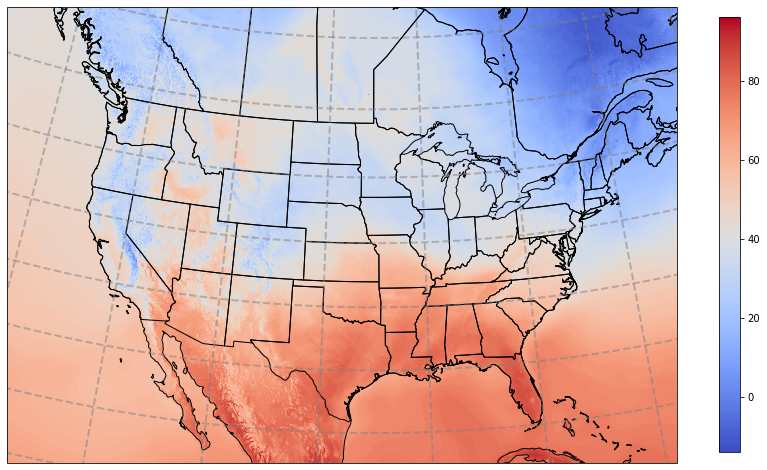

In [12]:
res = '50m'
fig = plt.figure(figsize=(15,10))

ax = plt.subplot(1,1,1,projection=projNative)
ax.set_extent((left,right,bottom,top),crs = projNative)
gl = ax.gridlines(linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax.add_feature(cfeature.COASTLINE.with_scale(res))

ax.add_feature (cfeature.STATES.with_scale(res))

cf=ax.pcolormesh(ras.x,ras.y,arr,cmap='coolwarm')

cbar = plt.colorbar(cf,shrink=0.8)